In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple

In [1]:
from custom_modules.generate_data import GenerateData

In [24]:
test_class = GenerateData(start_date='2021-01-01', end_date='2022-11-30', periodicity=['monthly'])

In [25]:
data = test_class.generate_data(campaign_start_date='2022-03-01', campaign_end_date='2022-11-30', total_obs=100)

In [26]:
data

,shopper_id,is_exposed,trt_start_date,shopper_mean,date,dollar_sales
0,44030,1,2022-03-06,4.35,2021-01-01,2.64
1,76127,1,2022-04-22,7.93,2021-01-01,10.42
2,10626,1,2022-04-19,8.07,2021-01-01,5.56
3,67889,1,2022-04-14,8.87,2021-01-01,12.08
4,27030,1,2022-03-05,0.69,2021-01-01,1.18
...,...,...,...,...,...,...
69895,12124,0,2022-03-11,6.38,2022-11-30,5.89
69896,26184,0,2022-03-20,7.50,2022-11-30,8.78
69897,23952,0,2022-03-23,9.95,2022-11-30,13.03
69898,74414,0,2022-03-03,6.58,2022-11-30,7.28


In [31]:
def plot_shopper_sales_series(data):
    """"Function to plot sales series for a random sample of shoppers, one from each group"""
    
    exposed_shoppers = data[data['is_exposed'] == True]['shopper_id'].unique()
    control_shoppers = data[data['is_exposed'] == False]['shopper_id'].unique()
    shopper_id_list = np.random.choice(exposed_shoppers, 1).tolist() + np.random.choice(control_shoppers, 1).tolist()

    fig, ax = plt.subplots(figsize=(15, 5))
    i = 1
    for shopper in shopper_id_list:
        data[data['shopper_id'] == shopper].plot(x='date', y='dollar_sales', ax=ax, label=f'{shopper}_{i}')
        i -= 1

    plt.legend()
    plt.show()

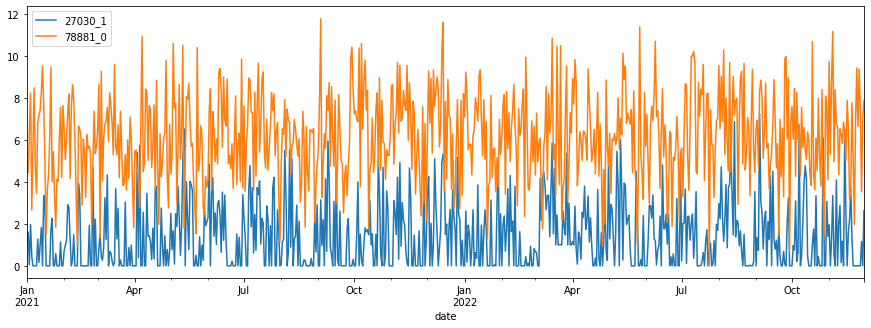

In [33]:
plot_shopper_sales_series(data = data)#, shopper_id_list = ['84971', '34877'])

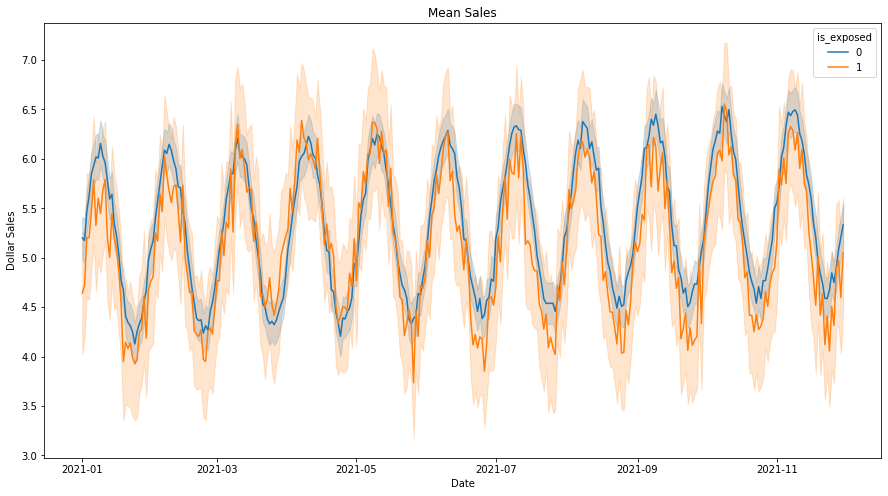

In [8]:
test_class.plot_mean_sales(df = data)

In [10]:
from sklearn.linear_model import LinearRegression

In [61]:
def create_lagged_features(data, time_col:str, num_lags:int = 1, lag_periodicity:int = 30, target_col:str = 'dollar_sales'):
    """Function to create lagged features
    Parameters
    -----------
    data (pd.DataFrame):
        The dataframe to create lagged features from
    time_col (str):
        The column name of the datetime column
    num_lags (int):
        The number of lagged features to create
    lag_periodicity (int):
        The periodicity of the lagged features
    
    
    Returns
    -----------
    A pd.DataFrame with lagged features
    """
    
    data = data.copy()
    data[time_col] = pd.to_datetime(data[time_col])
    data = data.sort_values(time_col)
    # data['date'] = data[time_col].dt.date
    data['month'] = data[time_col].dt.month
    data['year'] = data[time_col].dt.year
    data['day'] = data[time_col].dt.day
    
    # Create lagged features
    for i in range(1, num_lags):
        data[f'sales_lag_{i * lag_periodicity}'] = data.groupby('shopper_id')[target_col].shift(i * lag_periodicity)
        data[f'sales_lag_{i * lag_periodicity}'] = data[f'sales_lag_{i * lag_periodicity}'].fillna(0)
        
    # Drop rows with null values
    data.dropna(inplace=True)
    
    return data


In [62]:
ft_data = pd.concat([
    create_lagged_features(data = data, time_col='date', num_lags=12, lag_periodicity=30, target_col='dollar_sales'),
    create_lagged_features(data = data, time_col='date', num_lags=30, lag_periodicity=1, target_col='dollar_sales'),
    create_lagged_features(data = data, time_col='date', num_lags=1, lag_periodicity=365, target_col='dollar_sales')
], axis=0)

In [64]:
ft_data.fillna(0)

,shopper_id,is_exposed,trt_start_date,shopper_mean,date,dollar_sales,month,year,day,sales_lag_30,...,sales_lag_20,sales_lag_21,sales_lag_22,sales_lag_23,sales_lag_24,sales_lag_25,sales_lag_26,sales_lag_27,sales_lag_28,sales_lag_29
0,44030,1,2022-03-06,4.35,2021-01-01,2.64,1,2021,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,12286,0,2022-03-08,7.69,2021-01-01,7.49,1,2021,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,37109,0,2022-04-14,0.16,2021-01-01,0.00,1,2021,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,29979,0,2022-04-11,2.46,2021-01-01,0.00,1,2021,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,52721,0,2022-04-26,1.69,2021-01-01,5.75,1,2021,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69827,62360,0,2022-03-03,8.65,2022-11-30,8.68,11,2022,30,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69826,74274,0,2022-04-23,9.96,2022-11-30,10.92,11,2022,30,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69825,37334,0,2022-03-23,7.88,2022-11-30,8.47,11,2022,30,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69835,35585,0,2022-04-23,1.73,2022-11-30,2.33,11,2022,30,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
def de_trend_series(data, id_col:str, time_col:str, target_col:str, periodicity:str = 'monthly'):
    """Function to de-trend a time series"""
        
    data = data.copy()
    data[time_col] = pd.to_datetime(data[time_col])
    data = data.sort_values(time_col)
    data['month'] = data[time_col].dt.month
    data['year'] = data[time_col].dt.year
    data['day'] = data[time_col].dt.day
    
    # Create lagged features
    for i in range(1, 12):
        data[f'sales_lag_{i * 30}'] = data.groupby(id_col)[target_col].shift(i * 30)
        data[f'sales_lag_{i * 30}'] = data[f'sales_lag_{i * 30}'].fillna(0)
    
    # Drop rows with null values
    data.dropna(inplace=True)
    
    # Create a linear regression model
    model = LinearRegression()
    
    # Fit the model
    model.fit(data[[f'sales_lag_{i * 30}' for i in range(1, 12)]], data[target_col])
    
    # Create predictions
    data['predictions'] = model.predict(data[[f'sales_lag_{i * 30}' for i in range(1, 12)]])
    
    # Create a column for the residuals
    data['residuals'] = data[target_col] - data['predictions']
    
    return data

In [69]:
detrended_data = de_trend_series(data = data, id_col='shopper_id', time_col='date', target_col='dollar_sales', periodicity='monthly')

<AxesSubplot:xlabel='date'>

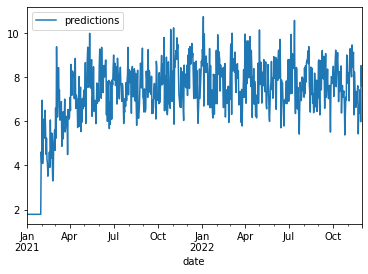

In [74]:
detrended_data.query('shopper_id == "12286"').plot(x='date', y='predictions')